In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error

In [ ]:
train_for = 735
predict_for = 14

In [ ]:
look_back = 50

def prepare_data(df):
    X = []
    y = []
    for i in range(look_back, len(df)):
        y.append(df[i])
        X.append(df[i - look_back:i])
    return np.array(X), np.array(y)

In [ ]:
def scale(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.fit_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

def descaled(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.inverse_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

In [ ]:
class Model:
  def __init__(self, df):
    self.scaler = MinMaxScaler()
    self.df = scale(df, self.scaler)
    self.dfw, self.dfy = prepare_data(self.df)

    self.model_strong = Sequential()
    self.model_strong.add(LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)))
    self.model_strong.add(LSTM(units = 32, return_sequences=True))
    self.model_strong.add(LSTM(units = 32))
    self.model_strong.add(Dense(units = 1))  #our predictions
    # self.model_strong.compile(optimizer = 'adam', loss = tf.keras.losses.CosineSimilarity(axis=1))
    self.model_strong.compile(optimizer = 'adam', loss = "mean_squared_error")




    self.model_weak = Sequential()

    self.model_weak.add(LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)))
    self.model_weak.add(Dropout(0.2))
    self.model_weak.add(LSTM(units = 32, return_sequences=True))
    self.model_weak.add(Dropout(0.2))
    self.model_weak.add(LSTM(units = 32))
    self.model_weak.add(Dropout(0.2))
    self.model_weak.add(Dense(units = 1))  #our predictions
    self.model_weak.compile(optimizer = 'adam', loss = "mean_squared_error")

  def fit(self):
    # when giving 25% importance to strong model and 75% importance to weak model
    y_train_strong = self.dfy * (3/4)
    y_train_weak = self.dfy / 4
    # training the strong model for more epochs
    self.model_strong.fit(self.dfw, y_train_strong, epochs = 20)
    # training the weak model for less epochs
    self.model_weak.fit(self.dfw, y_train_weak, epochs = 10)
  
  def predict(self, predict_for):
    df_full = self.dfw[-1]

    X_p_strong = [df_full]
    X_p_weak = [df_full]
    y_p_strong = []
    y_p_weak = []

    for i in range(predict_for):
        yi_strong = self.model_strong.predict(np.array(X_p_strong))
        y_p_strong.append(yi_strong[0][0])
        yi_weak = self.model_weak.predict(np.array(X_p_weak))
        y_p_weak.append(yi_weak[0][0])
        X_p_strong = [np.append(X_p_strong[0][1:], yi_strong)]
        X_p_weak = [np.append(X_p_weak[0][1:], yi_weak)]
    y_p = [0 for y_p_i in range(len(y_p_strong))]
    for j in range(len(y_p)):
        y_p[j] = y_p_strong[j] + y_p_weak[j]
    return descaled(y_p, self.scaler)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def smoothen(df, period):
    df_ma = df.copy()
    for i in range(period, len(df)):
        ma = 0
        for j in range(i - period + 1, i + 1):
            ma += df[j]
        df_ma[i] = ma / period
    return df_ma

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/covid-final-all.csv')
df['state_residence'] = df.apply(lambda row: row['state_residence'].lower(), axis=1)
df=df.groupby(['Date']).agg({'F_pos': 'sum', 'M_pos': 'sum', 'T_pos':'sum', 'NIA_pos':'sum', 'new_case': 'sum'}).reset_index()

date = df.iloc[train_for + 1]['Date']


df_f = df['F_pos'].values
df_m = df['M_pos'].values
df_t = df['T_pos'].values
df_nia = df['NIA_pos'].values

# df_f = smoothen(df_f, 3)
# df_m = smoothen(df_m, 3)
# df_t = smoothen(df_t, 3)
# df_nia = smoothen(df_nia, 5)

df_total = df_f + df_m + df_t + df_nia

In [ ]:
df_total.shape

(1093,)

In [ ]:
df_train = df_total[:train_for]
df_test = df_total[train_for:train_for+predict_for]

In [ ]:
model_f = Model(df_f[:train_for])
model_m = Model(df_m[:train_for])
model_t = Model(df_t[:train_for])
model_nia = Model(df_nia[:train_for])

model_f.fit()
model_m.fit()
model_t.fit()
model_nia.fit()

Epoch 1/20
22/22 [==============================] - 6s 15ms/step - loss: 0.0111
Epoch 2/20
22/22 [==============================] - 0s 14ms/step - loss: 0.0044
Epoch 3/20
22/22 [==============================] - 0s 15ms/step - loss: 0.0026
Epoch 4/20
22/22 [==============================] - 0s 12ms/step - loss: 0.0022
Epoch 5/20
22/22 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 6/20
22/22 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 7/20
22/22 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 8/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 9/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0015
Epoch 10/20
22/22 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 11/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 12/20
22/22 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 13/20
22/22 [==================

In [ ]:
def mape_(p, a):
  m = 0.0
  for i in range(len(p)):
    m += abs(p[i] - a[i]) / a[i]
  return( m / len(p)) * 100

In [ ]:
predictions = model_f.predict(predict_for) + model_m.predict(predict_for) + model_t.predict(predict_for) + model_nia.predict(predict_for)

for i in range(len(predictions)):
  predictions[i] = max(0, predictions[i])

actual = df_test

MAPE = mape_(predictions, actual)
print("MAPE:", MAPE)

1/1 [==============================] - 0s 25ms/step
MAPE: 48.21295000136043


In [ ]:
print(MAPE)

48.21295000136043


In [ ]:
print(predictions)

[ 91898.03 115277.74 134422.7  148275.77 157085.42 161729.27 163266.05
 162677.17 160751.1  158056.88 154966.67 151698.86 148364.34 145005.73]


In [ ]:
print(actual)

[210776. 151380. 296174. 294333. 301381. 299915. 271531. 282285. 192189.
 395946. 378298. 380601. 366328. 355254.]


In [ ]:
import matplotlib.pyplot as plt
def append(a, b):
  c = []
  for ai in a:
    c.append(ai)
  for bi in b:
    c.append(bi)
  return c

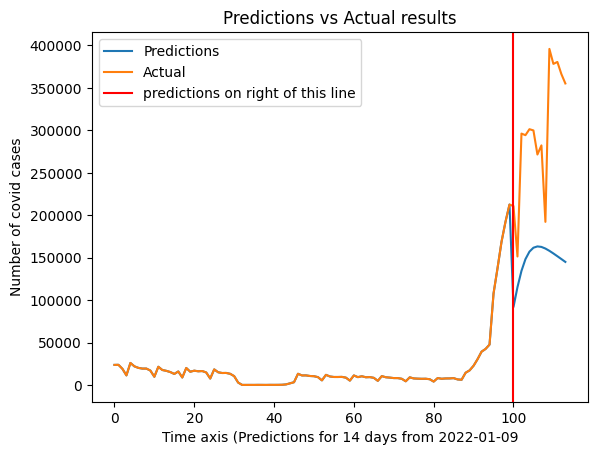

In [ ]:
window = 100
plt.figure()
plt.title("Predictions vs Actual results")
plt.plot(append(df_total[train_for - window:train_for], predictions), label="Predictions")
plt.plot(append(df_total[train_for - window:train_for], actual), label="Actual")
plt.xlabel("Time axis (Predictions for 14 days from " + date)
plt.ylabel("Number of covid cases")
plt.axvline(window, color = 'red', label = "predictions on right of this line")
plt.legend()
plt.show()

In [ ]:
model_f.model_strong.save("/content/drive/MyDrive/saved_models/model_strong_f" + date + ".h5")
model_m.model_strong.save("/content/drive/MyDrive/saved_models/model_strong_m" + date + ".h5")
model_t.model_strong.save("/content/drive/MyDrive/saved_models/model_strong_t" + date + ".h5")
model_nia.model_strong.save("/content/drive/MyDrive/saved_models/model_strong_nia" + date + ".h5")

In [ ]:
model_f.model_weak.save("/content/drive/MyDrive/saved_models/model_weak_f" + date + ".h5")
model_m.model_weak.save("/content/drive/MyDrive/saved_models/model_weak_m" + date + ".h5")
model_t.model_weak.save("/content/drive/MyDrive/saved_models/model_weak_t" + date + ".h5")
model_nia.model_weak.save("/content/drive/MyDrive/saved_models/model_weak_nia" + date + ".h5")